# Predicting Positive Responders for a Marketing Campaign
Author: David O. Laditan



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

For this project I will be following the workflow which was used in lab 3: Split data into training and test set. Use the training portion to find the best model using grid search and cross-validation. Evaluate the *winner* on the test set.

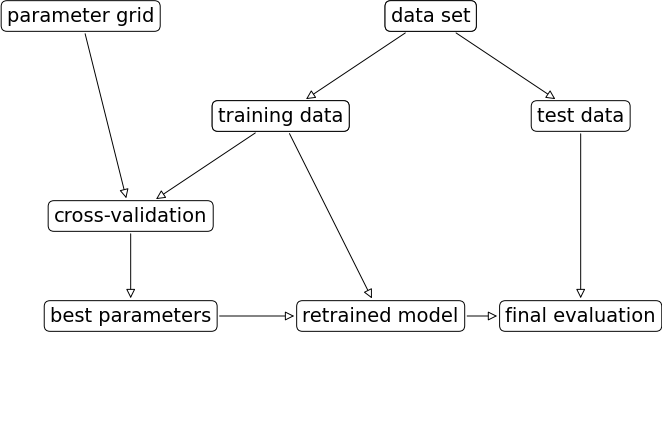

In [101]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function definitions

In [4]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation score of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    scores = cross_validate(model, X, y, scoring= scoring, cv=cv, return_train_score=True)
    train_score_mean = scores['train_score'].mean()
    val_score_mean = scores['test_score'].mean()
    
    return train_score_mean, val_score_mean
     
    

In [5]:
def print_grid_search_result(grid_search):
    '''Prints best parameters and mean training and validation scores of a grid search object.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        scores are printed with 3 decimal places.
        
    '''
    print(grid_search.best_params_)
    print("training score = {:.3f}; validation score = {:.3f}".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_],\
                                                             grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))
    
    

In [6]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [155]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    
    matrix = confusion_matrix(y_actual, y_pred)
    sns.heatmap(matrix, square= True, annot= True, xticklabels= labels, yticklabels= labels, cbar= False, cmap = 'PRGn', fmt = 'd')
    plt.title(title)
    plt.xlabel("predicted value")
    plt.ylabel("true value")
    
   

## 1. Load data
Dataset: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#


### 1.1 Prepare a pandas dataframe of all data

Load the bank marketing data set into a `DataFrame` variable `df_data`. The delimiter used in the csv file is ";".


In [240]:
df_data = pd.read_csv("bank-additional.csv",delimiter=";")
df_data.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [241]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

### 1.2 Prepare the feature matrix and target vector

Load the bank marketing data set into feature matrix `X` and target vector `y`.

Print shape and type of `X`, `y`.

In [242]:
from sklearn.model_selection import train_test_split
# get all columns apart from y for the features
X = df_data.drop("y", axis=1)
y = df_data.y

print("The shape of X is {} and type is {}".format(X.shape, type(X)))
print("The shape of y is {} and type is {}".format(y.shape, type(X)))



The shape of X is (4119, 20) and type is <class 'pandas.core.frame.DataFrame'>
The shape of y is (4119,) and type is <class 'pandas.core.frame.DataFrame'>


In [243]:
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,admin.,married,basic.6y,no,yes,yes,cellular,jul,thu,53,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1
4115,39,admin.,married,high.school,no,yes,no,telephone,jul,fri,219,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1
4116,27,student,single,high.school,no,no,no,cellular,may,mon,64,2,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1
4117,58,admin.,married,high.school,no,no,no,cellular,aug,fri,528,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1


## 2. Inspect the data 

### 2.1 View summary statistics



In [244]:
df_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### 2.2 Class (im)balance
Use `value_counts()` on the target vector `y` to report the number of samples in each class to check class imbalance.

In [245]:
y.value_counts()


no     3668
yes     451
Name: y, dtype: int64

Given the above values, the classes are imbalanced. Hence, the train-test splits need to be stratified.


## 3. Preprocessing
In this dataset, some features are discrete and nominal and need to be encoded while some are continuous. I will use a `OneHotEncoder` for the nominal features and use a `StandardScaler` for the continuous features.

The target vector is discrete and nominal as well. While sklearn is OK using string labels, I will use a `LabelEncoder` to convert strings to integers and keep the encoder to translate between the two representations.

### 3.1 Onehot encoding and standard scaling of features
Use a `ColumnTransformer` to convert `X` into one-hot-encoded features for categorical features and a `StandardScaler` for the continuous features. The transformed features is stored in a varible `X_enc`.

In [246]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder

ct = ColumnTransformer(
    [("scaling", StandardScaler(), make_column_selector(dtype_exclude=object)),
     ("onehot", OneHotEncoder(sparse=False), make_column_selector(dtype_include=object))])

X_enc = ct.fit_transform(X)

In [247]:
X_enc.shape

(4119, 63)

### 3.2 Label encode target vector 
I used the `LabelEncoder` to encode the target vector `y`, saved in a varibale `y_enc`.



In [248]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)
print(y_enc.shape)
print(le.classes_)

(4119,)
['no' 'yes']


## 4. Create training and test sets
Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, `stratify=y`. I split `X_enc` and `y_enc` into training and test sets.

In [249]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2,stratify=y, random_state=37)


## 5. Compare models using cross-validation
Creating a list containing a `LogisticRegression()`, 
          `SVC()`,
          `GaussianNB()`,
        `RandomForestClassifier(random_state=55)`, 
         `GradientBoostingClassifier(random_state=56)` objects.

I iterate this list, then:
- compute the **average precision** using `get_classifier_cv_score()` defined above, 
- rank the models based on validation **average precision** (best first),
- and print the ranked models training and validation scores with **3 decimal places**. 

I use training data and 7-fold cross-validation.

In [250]:
# TODO: add cross-validation comparison here
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

results = []
models = [LogisticRegression(max_iter=10000),  SVC(),  GaussianNB(),\
          RandomForestClassifier(random_state=55), GradientBoostingClassifier(random_state=56)]

for model in models:
    train_score, val_score = get_classifier_cv_score(model, X_train_scaled, y_train, scoring = 'average_precision')
    results.append((val_score, train_score, model))
    
sorted_result = sorted(results, reverse = True)

for train_score, test_score, model in sorted_result:
    print("{} train_score = {:.3f}, validation_score = {:.3f}".format(model.__class__.__name__,train_score, test_score))

GradientBoostingClassifier train_score = 0.606, validation_score = 0.873
LogisticRegression train_score = 0.604, validation_score = 0.642
RandomForestClassifier train_score = 0.594, validation_score = 1.000
SVC train_score = 0.591, validation_score = 0.826
GaussianNB train_score = 0.377, validation_score = 0.392


## 6. Hyperparameter tuning using grid search with pipeline

The inital cross-validation above showed that both DecisionTree based models might have merit. 

Support vector machine classifier might also perform well if properly tuned.

Next, hyperparameters are tuned using grid search.

### 6.1 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(random_state=55)`.

I use a pipeline to chain the PCA and classifier steps.

The grid search uses a 7-fold cross-validation, and `average_precision` as the scoring function. 

After several iterations, I settled on using the following values for my hyperparameters because the best grid search result had the values fall in the middle the given range:
- `'n_estimators': [100, 200, 500, 700, 1000]`
- `'max_depth': [5,7,10,50]`
- `'n_components': 5, 10, 20]`


In [256]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe = Pipeline(steps=[('reduce_dim', PCA()), 
                      ('classifier', RandomForestClassifier(random_state=55))])
                      

In [257]:
from sklearn.model_selection import GridSearchCV
param_grid = {'reduce_dim__n_components':[5, 10, 20],\
              'classifier__n_estimators': [100, 200, 500, 700, 1000],\
             'classifier__max_depth': [5,7,10,50]}
             
grid_rf = GridSearchCV(pipe, param_grid, scoring= "average_precision",\
                    cv = 7, n_jobs = 4, return_train_score = True)

In [258]:
#perform the grid search by calling fit()
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('reduce_dim', PCA()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=55))]),
             n_jobs=4,
             param_grid={'classifier__max_depth': [5, 7, 10, 50],
                         'classifier__n_estimators': [100, 200, 500, 700, 1000],
                         'reduce_dim__n_components': [5, 10, 20]},
             return_train_score=True, scoring='average_precision')

In [91]:
print_grid_search_result(grid_rf)

{'classifier__max_depth': 7, 'classifier__n_estimators': 500, 'reduce_dim__n_components': 10}
training score = 0.895; validation score = 0.608


### 6.2 Gradient boosting classifier 
Perform grid search using `GridSearchCV` for the `GradientBoostingClassifier(random_state=56)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. 

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 500, 700, 1000]`,
- `'learning_rate': [0.001, 0.01, 0.1, 1.0]`,
- `'max_depth': [3, 5, 7]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [97]:
pipe = Pipeline(steps=[('reduce_dim', PCA()), 
                      ('classifier', GradientBoostingClassifier(random_state=56))])

In [98]:
param_grid = {'reduce_dim__n_components':[20, 30, 50, 63],\
              'classifier__n_estimators': [ 100, 200, 500, 700, 1000],\
             'classifier__learning_rate': [0.001, 0.01, 0.1, 1.0], \
             'classifier__max_depth': [3, 5, 7]}
             

In [99]:
# Setup grid search for GradientBoostingClassifier(max_depth=5, random_state=56)

grid_gbc = GridSearchCV(pipe, param_grid,\
                    scoring = 'average_precision', cv = 7, n_jobs = 4, return_train_score= True)

In [100]:
# perform the grid search by calling fit()
grid_gbc.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('reduce_dim', PCA()),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=56))]),
             n_jobs=4,
             param_grid={'classifier__learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200, 500, 700, 1000],
                         'reduce_dim__n_components': [20, 30, 50, 63]},
             return_train_score=True, scoring='average_precision')

In [105]:
# call print_grid_search_result() to print the results
print_grid_search_result(grid_gbc)

{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 1000, 'reduce_dim__n_components': 63}
training score = 0.923; validation score = 0.592


### 6.3 SVC grid search
Perform grid search using `GridSearchCV` for the `SVC()`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function.

Use the following hyperparameters and values:
- `'C': [10, 100, 150, 200]`
- `'gamma': [0.0001, 0.001, 0.01,0.1, 1, 10]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [254]:
pipe = Pipeline(steps=[('reduce_dim', PCA()), 
                      ('classifier', SVC())])

In [133]:
# Setup grid search for SVC()
param_grid = {'reduce_dim__n_components':[20, 30, 50, 63],\
              'classifier__C': [10, 100, 150, 200],\
             'classifier__gamma': [0.0001, 0.001, 0.01,0.1, 1, 10]}

In [134]:

grid_svc = GridSearchCV(pipe, param_grid, scoring = "average_precision", n_jobs = 4, cv = 7, return_train_score=True)

In [124]:
# perform the grid search by calling fit()
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('reduce_dim', PCA()),
                                       ('classifier', SVC())]),
             n_jobs=4,
             param_grid={'classifier__C': [10, 100, 150, 200],
                         'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'reduce_dim__n_components': [20, 30, 50, 63]},
             return_train_score=True, scoring='average_precision')

In [125]:
# call print_grid_search_result() to print the results
print_grid_search_result(grid_svc)

{'classifier__C': 100, 'classifier__gamma': 0.001, 'reduce_dim__n_components': 50}
training score = 0.676; validation score = 0.605


### Grid search summary

Random Forest Classifier:
training score = 0.895; validation score = 0.608

Gradient Boosting Classifier:
training score = 0.923; validation score = 0.592

SVC: 
training score = 0.676; validation score = 0.605



## 7. Best model: Find a better threshold

### 7.1 Precision and recall curve

From the results above, it looks like `RandomForestClassifier()` performs well.

Using the training dataset and best `RandomForestClassifier()` from the grid search above, I do the following::
1. Calculate predicted probabilities using `cross_val_predict()` with parameters `cv=7, method='predict_proba'`.
2. Plot the precision-recall curve indicating where the default threshold 0.5 lies .




In [259]:
# Calculate predicted probabilities using cross_val_predict(cv=7, method='predict_proba')

from sklearn.model_selection import cross_val_predict

y_pred_proba = cross_val_predict(grid_rf.best_estimator_, X_train, y_train, cv=7, method='predict_proba')

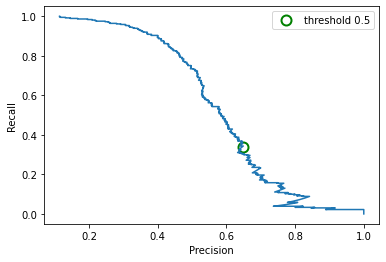

In [260]:
# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_train, y_pred_proba[:,1])

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))

plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], 'o', c='g',
         markersize=10, label="threshold 0.5", fillstyle="none", mew=2)

plt.plot(precision_rf, recall_rf)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

### 7.2 Find a better threshold
My assumption for this application is that we want the marketing campaign to have as minimal negative responses as possible, this because the bank is working on a tight marketing budget. We only want to market to people whom we are relatively confident will say yes. Hence, it is important in this application to achieve high precision. Considering the validation scores for the models currently trained are not that high, I set my desired precision value for 0.7. This is reasonable for business in that we can market to a subset of the bank's customers knowing that there is a likelihood that 80% of them will say yes to the offer.   

In [233]:
#TODO: Find and print threshold for recall>0.999
desired_precision = 0.70
idx = np.argwhere(precision_rf <= desired_precision)[-1]
idx
thresh_desired_precision = thresholds_rf[idx]
print(thresh_desired_precision)

[0.61393395]


## 8. Retrain best model
Retrain the best `RandomForestClassifier()` from the grid search above on the training dataset.

In [234]:
#Retrain random forest classifier
grid_rf.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('reduce_dim', PCA(n_components=10)),
                ('classifier',
                 RandomForestClassifier(max_depth=7, n_estimators=500,
                                        random_state=55))])

## 9. Evaluate on test data


### 9.1 Evaluation with default threshold

In [235]:
# print classification report using default threshold
from sklearn.metrics import classification_report

y_pred_default =  grid_rf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       734
           1       0.69      0.38      0.49        90

    accuracy                           0.91       824
   macro avg       0.81      0.68      0.72       824
weighted avg       0.90      0.91      0.90       824



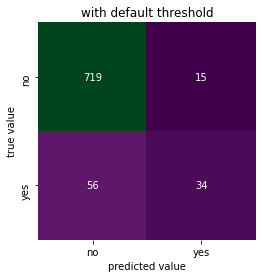

In [236]:
#call plot_confusion_matrix()
plot_confusion_matrix(y_test, y_pred_default, ["no", "yes"], title='with default threshold')

### 9.2 Evaluation with new threshold form Step 7.

In [261]:
y_pred_higher_threshold = grid_rf.best_estimator_.predict_proba(X_test) > thresh_desired_precision
y_pred_higher_threshold = y_pred_higher_threshold[:, 1].astype(int)

In [262]:
# print classification report using lower threshold
print(classification_report(y_test, y_pred_higher_threshold))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.73      0.21      0.33        90

    accuracy                           0.91       824
   macro avg       0.82      0.60      0.64       824
weighted avg       0.89      0.91      0.88       824



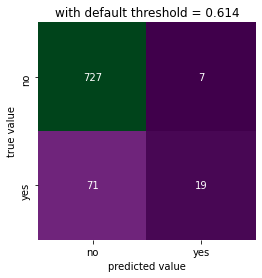

In [263]:
#call plot_confusion_matrix()
plot_confusion_matrix(y_test, y_pred_higher_threshold, ["no", "yes"], title= 'with default threshold = 0.614')


### Summary
#### What are the precision, recall and accuracy on the test set using the default and optimal thresholds of the best (tuned) random forest model?

Default threshold : 0.5

precision: 0.69     

recall: 0.38

accuracy: 0.91


Optimal threshold : 0.61

precision:  0.74      

recall: 0.22

accuracy:  0.91


#### How many false negatives does the model produce on the test set with the default and optimal thresholds of the best (tuned) random forest model.?

Default threshold : 0.5

False Positives: 15

Optimal threshold: 0.019

False positive: 7



## Interpretation

In conclusion, I will comment on the following items:
- In the classification of no vs yes responses for this application, why is high precision desired?
- In the classification of no vs yes responses for this application, what do false positive and false negative predictions mean and what are the consequences of making these mistakes?
- Is the fine-tuned model with new threshold satisfactory, i.e. a useful model for the task, or is more work needed? 


* For this application, a high precision is desired because we want to correctly identify the customers who will respond positively to the markting campain. The bank will market to only these customers and this will help to save marketing and advertisement costs.

* A false positive prediction means that we falsely predict that a customer will say yes to the offer, and this is what the bank wants to minimize. A false negative prediction means that we falsely predict that a customer will say no. However in this application, we don't care as much about these cases.

* The best trained model which is the random forest model is not that great. I achieved an `average_precision` validation score of 0.608. This means that more work is needed to get a better performing model. A better performing model in this case would be a model that has a higher True Postive prediction rate while also maintaining a high precision.

Having said that, the fine-tuned model is fairly useful for the task because I was  able to get a precision of 0.74 which is better than 0.69 of the default random forest model gotten from the grid search. It is important to note that the high f1-score seen in the classification report doesn't say much about how accurate our model is in reality but how biased the training data is to "no" outcomes. If the model predicted "no" for all data points, it will still have a high f1-score.    



## Reflection

I was able to compare the performance of different classifiers on this dataset and practice using pipelines which were my two goals for this project. I would however have liked to improve the performance of my gradient boosted classifier, but with my computer resources the amount of time it took to run a grid search for hyperparameter tuning did not allow me to achieve this. 
 

